# Outlook #

In this colab we will investigate the **value iteration** and **policy iteration** algorithms in a maze environment.

# Installation #

In [1]:
if get_ipython().__class__.__module__ == "google.colab._shell":
    !apt-get install ffmpeg

In [2]:
try:
    import my_gym
except ModuleNotFoundError as e:
    !pip install git+https://github.com/osigaud/my_gym

Matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from mazemdp.maze_plotter import show_videos
from my_gym.envs.maze_mdp import MazeMDPEnv

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

# Agents and MDPs #




A reinforcement learning agent interacts with an environment represented as a Markov Decision Process (MDP). It is defined by a tuple $(S, A, P, r, \gamma)$ where $S$ is the state space, $A$ is the action space, $P(state_t, action_t, state_{t+1})$ is the transition function, $r(state_t, action_t)$ is the reward function and $\gamma \in [0, 1]$ is the discount factor.



In what follows we import code to create an MDP corresponding to a random maze (see https://github.com/osigaud/SimpleMazeMDP for documentation).

In [37]:
import gym
import my_gym


env = gym.make("MazeMDP-v0", kwargs={"width": 7, "height": 7, "ratio": 0.3})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.set_no_agent()
env.init_draw("The maze")

Output()

# Dynamic programming #


The goal of an RL agent is to find the optimal behaviour, defined by a policy $\pi$ that assigns an action (or distribution over actions) to each state so as to maximize the agent's total expected reward. In order to estimate how good a state is, either a state value function $V(x)$ or a state-action value function $Q(x,u)$ is used.

Dynamic programming algorithms are used for planning, they require a full knowledge of the MDP from the agent (in contrast to "true" RL where the agent does not know the transition and reward functions).
They find the optimal policy by computing a value function $V$ or an action-value function $Q$ over the state space or state-action space of the given MDP. **Value iteration** and **policy iteration** are two standard dynamic programming algorithms. You should study both of them using both $V$ and $Q$, as these algorithms contain the basic building blocks for most RL algorithms.


## Value Iteration ##

### Value Iteration with the V function ###



When using the $V$ function, **value iteration** aims at finding the optimal values $V^*$ based on the Bellman Optimality Equation:
$$V^*(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^*(y) \big],$$

where:

*   $r(s, a)$ is the reward obtained from taking action $a$ in state $s$,
*   $P(s, a, y)$ is the probability of reaching state $y$ when taking action $a$ in state $s$, 
*   $\gamma \in [0,1]$ is a discount factor defining the relative importance of long term rewards over short term ones (the closer to 0, the more the agent focuses on immediate rewards).

In practice, we start with an initial value function $V^0$ (for instance, the values of all states are 0), and then we iterate for all states $s$

$$V^{i+1}(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^i(y) \big],$$

until the values converge, that is $\forall s, V^{i+1}(s) \approx V^i(s)$. It is shown that at convergence, $\forall s, V^i(s)= V^*(s)$.

To visualize the policy obtained from **value iteration**, we need to first define the `get_policy_from_V()` function

In [38]:
def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    # Outputs a policy given the state values
    policy = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        if x not in mdp.terminal_states:
            # Compute the value of the state x for each action u of the MDP action space
            v_temp = []
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy


The `value_iteration_v(mdp)` function below provides the code of **value iteration** using the $V$ function. It is given as an example from which you can derive other instances of dynamic programming algorithms. Look at it more closely, this will help for later questions:

* you can ignore the `mdp.new_render()` and `mdp.render(...)` functions which are here to provide the visualization of the iterations.
* find in the code the loop over states, the main loop that performs these updates until the values don't change significantly anymore, the main update equation. Found them? OK, you can continue...


In [39]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def value_iteration_v(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False
    v_iterations = 0
    iterations = 0

    video_recorder = VideoRecorder(mdp, "videos/ValueIterationV.mp4", enabled=render)
    mdp.set_title("Value iteration V")
    if render:
        mdp.render()
        video_recorder.capture_frame()
    mdp.set_render_func(mdp.draw_v, lambda draw: draw(v))

    while not stop:
        v_old = v.copy()
        if render:
            mdp.render()
            video_recorder.capture_frame()

        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if x not in mdp.terminal_states:
                v_temp = []
                for u in mdp.action_space.actions:
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)

                # Select the highest state value among those computed
                v[x] = np.max(v_temp)
                v_iterations += 1
        iterations += 1

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    if render:
        policy = get_policy_from_v(mdp, v)
        mdp.set_render_func(mdp.draw_v_pi, lambda draw: draw(v, policy))
        mdp.render()
        video_recorder.capture_frame()


    video_recorder.close()
    return v, v_list, v_iterations, iterations

Let us run it on the previously defined MDP

In [40]:
v, v_list, v_updates, iterations = value_iteration_v(env, render=True)
print(v_updates, iterations)

Output()

476 14


### Value iteration with the $Q$ function ###


The state-action value function $Q^{\pi}(s,a)$ defines the value of being in state $s$, taking action $a$ then following policy $\pi$. The Bellman Optimality Equation for $Q^*$ is
$$ Q^*(s,a) =  r(s,a) + \gamma \sum_{y} P(s,a,y) \max_{a'}Q^*(y,a'). $$ 


**Question:** By taking inspiration from the `value_iteration_v(mdp)` function above, fill the blank (given with '\#Q[x,u]=...') in the code of `value_iteration_q(mdp)`.

In [41]:

# ------------------ Value Iteration with the Q function ---------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function


from re import A


def value_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    stop = False

    q_updates = 0
    iterations = 0

    if render:
        mdp.init_draw("Value iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Value iteration Q")

        for x in range(mdp.nb_states):
            if x not in mdp.terminal_states:
                for u in mdp.action_space.actions:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[x, u, y] * np.max(qold[y, :])
                        
                    q[x,u]= mdp.r[x, u] + mdp.gamma * summ
                    q_updates += 1

        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))
        iterations += 1

    if render:
        mdp.draw_v(q, title="Value iteration Q")
        mdp.mdp.plotter.video_writer.release()

    return q, q_list, q_updates, iterations


Once you are done, run it.

In [1]:
q, q_list, q_updates, iterations = value_iteration_q(env, render=True)
print(q_updates, iterations)

NameError: name 'MazeMDPEnv' is not defined

## Policy Iteration ##


The **policy iteration** algorithm is more complicated than **value iteration**.
Given a MDP and a policy $\pi$, **policy iteration** iterates the following steps: 

*   Evaluate policy $\pi$: compute $V$ or $Q$ based on the policy $\pi$;
*   Improve policy $\pi$: compute a better policy based on $V$ or $Q$.

This process is repeated until convergence, i.e. when the policy cannot be improved anymore.


### Policy iteration with the $V$ function ###

When using $V$, $V^{\pi}(s)$ is the expected return when starting from state $s$ and following policy $\pi$. It is processed based on the Bellman Optimality Equation for deterministic policies:

$$V^\pi(s) = r(s, \pi(s)) + \gamma \sum_{y \in S}P(s, \pi(s), y)V^\pi(y),$$


where:

*   $\pi$ is a deterministic policy, meaning that in a state $s$, the agent always selects the same action,
*   $V^\pi(y)$ is the value of the state $y$ under policy $\pi$.


Thus, given a policy $\pi$, one must first compute its value function $V^\pi(s)$ for all states $s$ iterating the Bellman Optimality Equation until convergence, that is using **value iteration**.
Then, one must determine if policy $\pi$ can be improved based on $V$. For that, in each state $s$, one can compute the Q-value $Q(s,a)$ of applying action $a$ and then following policy $\pi$ based on the just computed $V^\pi$, and replace the action $\pi(s)$ with $\arg\max_a Q(s,a)$.



In order to facilitate the coding of **policy iteration** algorithms, we first define a set of useful functions.

The `improve_policy_from_v(mdp, v, policy)` function is very similar to the `get_policy_from_v(v)` function which was given above. The main difference is that it takes a policy as argument and improves this policy when possible, thus is is more in the spirit of the `policy improvement` step of **policy iteration**. But both functions can be used interchangeably.

The functions `evaluate_one_step_v(mdp, v, policy)`, where `mdp` is a given MDP, `v` is some value function in this MDP and `policy` is some policy and the function `evaluate_v(mdp, policy)` are also given. These functions are used to build the value function $V^\pi$ corresponding to policy $\pi$.


In [43]:
def improve_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            v_temp = np.zeros(mdp.action_space.size)
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ

            for u in mdp.action_space.actions:
                if v_temp[u] > v_temp[policy[x]]:
                    policy[x] = u
    return policy

In [44]:
def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_updates = 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
            v_updates += 1
    return v_new, v_updates



In [45]:

def evaluate_v(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    v_updates = 0
    while not stop:
        vold = v.copy()
        v, v_step_updates = evaluate_one_step_v(mdp, vold, policy)
        v_updates += v_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
    return v, v_updates


To perform **policy iteration** we also need an initial random policy.

In [46]:
from mazemdp import random_policy

**Question:** By using the above functions, fill the code of the `policy_iteration_v(mdp)` function below.

In [47]:
# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes 
# the optimal state value function V and the optimal policy

def policy_iteration_v(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False
    v_updates_total = 0
    iterations = 0

    if render:
        mdp.init_draw("Policy iteration V")

    while not stop:
        vold = v.copy()
        # Step 1 : Policy Evaluation
        v, v_updates = evaluate_v(mdp, policy)
        v_updates_total += v_updates
        if render:
            mdp.draw_v_pi(v, policy, title="Policy iteration V")

        # Step 2 : Policy Improvement
        # À compléter...  
        policy = improve_policy_from_v(mdp, v, policy)
        
        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))
        iterations +=1

    if render:
        mdp.draw_v_pi(v, policy, title="Policy iteration V")
        mdp.mdp.plotter.video_writer.release()

    return v, v_list, v_updates_total, iterations


And finally run it.

In [48]:
v, v_list, v_updates, iterations = policy_iteration_v(env, render=True)
print(v_updates, iterations)

Output()

3570 11


### Policy iteration with the $Q$ function ###


The **policy iteration** algorithm with the $Q$ function is the same as with the $V$ function, but the policy improvement step is more straightforward.

When using $Q$, the Bellman Optimality Equation with deterministic policy $\pi$ for $Q$ becomes: 
$$Q^{\pi}(s,a) = r(s,a) + \gamma \sum_{y \in S}P(s,a,y)Q^{\pi}(y,\pi(y)).$$

The policy can then be updated as follows:
$$\pi^{(t+1)}(s) = \arg\max_aQ^{\pi^{(t)}}(s,a).$$


First, we need to determine a policy from the $Q$ function.

**Question:**  fill the `get_policy_from_q(q)` function, where $q$ is the state-action value function.

In [49]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

**Question:** By drawing inspiration on the functions give with the $v$ function, fill the code of the `evaluate_one_step_q(mdp, q, policy)` function below, where $q$ is some action value function, and the `evaluate_q(mdp, policy)` function.

In [50]:
def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_updates = 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                    
                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ
                q_updates += 1
    return qnew, q_updates

In [51]:

def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    q_updates = 0
    while not stop:
        qold = q.copy()
        q, q_step_updates = evaluate_one_step_q(mdp, q, policy)
        q_updates += q_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q, q_updates


**Question:** By using the above functions, fill the code of the `policy_iteration_q(mdp)` function below.

In [52]:
def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_updates = 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                    
                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ
                q_updates += 1
    return qnew, q_updates

def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    q_updates = 0
    while not stop:
        qold = q.copy()
        q, q_step_updates = evaluate_one_step_q(mdp, q, policy)
        q_updates += q_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q, q_updates
# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes 
# the optimal action value function Q and the optimal policy

def policy_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False
    q_total_updates = 0
    iterations = 0

    if render:
        mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        q, q_updates = evaluate_q(mdp, policy)
        q_total_updates += q_updates
        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)
        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))
        iterations += 1

    if render:
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, q_list, q_total_updates, iterations


Finally, run it.

In [53]:
q, q_list, q_updates, iterations = policy_iteration_q(env, render=True)
print(q_updates, iterations)

Output()

18768 14


### Study part: Experimental comparisons

We will now compare the efficiency of the various dynamic programming methods using either the $V$ or the  $Q$ functions.

In all your dymanic programming functions, add code to count the number of iterations and the number of elementary $V$ or $Q$ updates. Use the provided `mazemdp.Chrono` class to measure the time taken. You may generate various mazes of various sizes to figure out the influence of the maze topology.

Build a table where you compare the various dymanic programming functions in terms of iterations, elementary operations and time taken.

You can run the `plot_convergence_vi_pi(...)` function provided below to visualize the convergence of the various algorithms.


In [54]:

# ---- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax -----#

def plot_convergence_vi_pi(m, render):
    v, v_list1, v_updates1, v_iterations1 = value_iteration_v(m, render)
    q, q_list1, v_updates2, v_iterations2 = value_iteration_q(m, render)
    v, v_list2, q_updates1, q_iterations1 = policy_iteration_v(m, render)
    q, q_list2, q_updates2, q_iterations2 = policy_iteration_q(m, render)

    plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
    plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
    plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v')
    plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='best')
    # plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

**Question:** Run the code below and visualize the results of the different algorithms

Output()

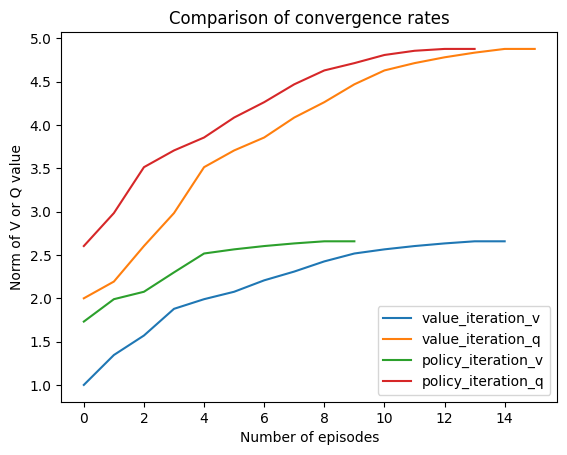

In [55]:
env = gym.make("MazeMDP-v0", kwargs={"width": 6, "height": 6, "ratio": 0.3}) 
env.init_draw("Maze")
plot_convergence_vi_pi(env, False)


In [ ]:
# Convergence and elemental updates by maze size

from mazemdp import chrono

def plot_iterations_updates_vi_pi(iterations, min_size, max_size):
    maze_sizes = np.arange(min_size, max_size)
    v_updates1 = np.zeros_like(maze_sizes, dtype = float)
    v_updates2 = np.zeros_like(maze_sizes, dtype = float)
    q_updates1 = np.zeros_like(maze_sizes, dtype = float)
    q_updates2 = np.zeros_like(maze_sizes, dtype = float)
    
    v_iterations1 = np.zeros_like(maze_sizes, dtype = float)
    v_iterations2 = np.zeros_like(maze_sizes, dtype = float)
    q_iterations1 = np.zeros_like(maze_sizes, dtype = float)
    q_iterations2 = np.zeros_like(maze_sizes, dtype = float)
    
    v_temps1 = np.zeros_like(maze_sizes, dtype = float)
    v_temps2 = np.zeros_like(maze_sizes, dtype = float)
    q_temps1 = np.zeros_like(maze_sizes, dtype = float)
    q_temps2 = np.zeros_like(maze_sizes, dtype = float)
    
    render = False
    for i, size in enumerate(maze_sizes):
        print("Processing size ", size)
        for j in range(iterations):
            env = gym.make("MazeMDP-v0", kwargs={"width": size, "height": size, "ratio": 0.4}) 
            # env.init_draw("Maze")
            t = chrono.time.time()
            v, v_list1, v_upd1, v_iter1 = value_iteration_v(env, render)
            v_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list1, q_upd1, q_iter1 = value_iteration_q(env, render)
            q_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            v, v_list2, v_upd2, v_iter2 = policy_iteration_v(env, render)
            v_temps2[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list2, q_upd2, q_iter2 = policy_iteration_q(env, render)
            q_temps2[i] += (chrono.time.time() - t)
            
            v_updates1[i] += v_upd1/iterations
            v_updates2[i] += v_upd2/iterations
            q_updates1[i] += q_upd1/iterations
            q_updates2[i] += q_upd2/iterations
            
            v_iterations1[i] += v_iter1/iterations
            v_iterations2[i] += v_iter2/iterations
            q_iterations1[i] += q_iter1/iterations
            q_iterations2[i] += q_iter2/iterations
    
    # Create two subplots and unpack the output array immediately
    f, axis = plt.subplots(3, 1, sharey=False)
    axis[0].plot(maze_sizes, v_updates1, label='value_updates_v')
    axis[0].plot(maze_sizes, q_updates1, label='value_updates_q')
    axis[0].plot(maze_sizes, v_updates2, label='policy_updates_v')
    axis[0].plot(maze_sizes, q_updates2, label='policy_updates_q')
    
    axis[1].plot(maze_sizes, v_iterations1, label='value_iterations_v')
    axis[1].plot(maze_sizes, q_iterations1, label='value_iterations_q')
    axis[1].plot(maze_sizes, v_iterations2, label='policy_iterations_v')
    axis[1].plot(maze_sizes, q_iterations2, label='policy_iterations_q')
    
    axis[2].plot(maze_sizes, v_temps1, label='value_iterations_v')
    axis[2].plot(maze_sizes, q_temps1, label='value_iterations_q')
    axis[2].plot(maze_sizes, v_temps2, label='policy_iterations_v')
    axis[2].plot(maze_sizes, q_temps2, label='policy_iterations_q')


    plt.xlabel('Maze size')
    
    axis[0].set_title('Elemental updates')
    axis[1].set_title('Number of iterations')
    axis[1].set_title('Time')
    
    axis[0].legend(loc='best')
    axis[1].legend(loc='best')
    axis[2].legend(loc='best')
    plt.savefig("comparison_DP9_on_size.png")
    plt.tight_layout()
    plt.show()


In [ ]:
    
plot_iterations_updates_vi_pi(50, 5,10)

In [ ]:
# Convergence and elemental updates by maze size

from mazemdp import chrono

def plot_iterations_updates_vi_pi_ratio():
    ratios = np.arange(0, 0.6, 0.05)
    v_updates1 = np.zeros_like(ratios)
    v_updates2 = np.zeros_like(ratios)
    q_updates1 = np.zeros_like(ratios)
    q_updates2 = np.zeros_like(ratios)
    
    v_iterations1 = np.zeros_like(ratios)
    v_iterations2 = np.zeros_like(ratios)
    q_iterations1 = np.zeros_like(ratios)
    q_iterations2 = np.zeros_like(ratios)
    
    render = False
    size = 6
    for i, ratio in enumerate(ratios):
        env = gym.make("MazeMDP-v0", kwargs={"width": size, "height": size, "ratio": ratio}) 
        v, v_list1, v_updates1[i], v_iterations1[i] = value_iteration_v(env, render)
        q, q_list1, q_updates1[i], q_iterations1[i] = value_iteration_q(env, render)
        v, v_list2, v_updates2[i], v_iterations2[i] = policy_iteration_v(env, render)
        q, q_list2, q_updates2[i], q_iterations2[i] = policy_iteration_q(env, render)
        
    # Create two subplots and unpack the output array immediately
    f, axis = plt.subplots(2, 1, sharey=False)
    axis[0].plot(ratios, v_updates1, label='value_updates_v')
    axis[0].plot(ratios, q_updates1, label='value_updates_q')
    axis[0].plot(ratios, v_updates2, label='policy_updates_v')
    axis[0].plot(ratios, q_updates2, label='policy_updates_q')
    
    axis[1].plot(ratios, v_iterations1, label='value_iterations_v')
    axis[1].plot(ratios, q_iterations1, label='value_iterations_q')
    axis[1].plot(ratios, v_iterations2, label='policy_iterations_v')
    axis[1].plot(ratios, q_iterations2, label='policy_iterations_q')


    plt.xlabel('Maze size')
    axis[0].set_title('Number of elementary updates')
    axis[1].set_title('Number of iterations until convergence')
    axis[0].legend(loc='best')
    axis[1].legend(loc='best')
    # plt.savefig("comparison_DP.png")
    plt.tight_layout()
    plt.show()
    
plot_iterations_updates_vi_pi_ratio()


Given the results above, discuss the relative computational efficiency of these methods.

### Study part: Generalized Policy Iteration

Code the **generalized policy iteration** algorithm and study the influence of the number of evaluation steps between each improvement step

In [ ]:
# Convergence and elemental updates by maze size

from mazemdp import chrono

def plot_iterations_updates_vi_pi(iterations, min_size, max_size):
    maze_sizes = np.arange(min_size, max_size)
    v_updates1 = np.zeros_like(maze_sizes, dtype = float)
    v_updates2 = np.zeros_like(maze_sizes, dtype = float)
    q_updates1 = np.zeros_like(maze_sizes, dtype = float)
    q_updates2 = np.zeros_like(maze_sizes, dtype = float)
    
    v_iterations1 = np.zeros_like(maze_sizes, dtype = float)
    v_iterations2 = np.zeros_like(maze_sizes, dtype = float)
    q_iterations1 = np.zeros_like(maze_sizes, dtype = float)
    q_iterations2 = np.zeros_like(maze_sizes, dtype = float)
    
    v_temps1 = np.zeros_like(maze_sizes, dtype = float)
    v_temps2 = np.zeros_like(maze_sizes, dtype = float)
    q_temps1 = np.zeros_like(maze_sizes, dtype = float)
    q_temps2 = np.zeros_like(maze_sizes, dtype = float)
    
    render = False
    for i, size in enumerate(maze_sizes):
        print("Processing size ", size)
        for j in range(iterations):
            env = gym.make("MazeMDP-v0", kwargs={"width": size, "height": size, "ratio": 0.4}) 
            # env.init_draw("Maze")
            t = chrono.time.time()
            v, v_list1, v_upd1, v_iter1 = value_iteration_v(env, render)
            v_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list1, q_upd1, q_iter1 = value_iteration_q(env, render)
            q_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            v, v_list2, v_upd2, v_iter2 = policy_iteration_v(env, render)
            v_temps2[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list2, q_upd2, q_iter2 = policy_iteration_q(env, render)
            q_temps2[i] += (chrono.time.time() - t)
            
            v_updates1[i] += v_upd1/iterations
            v_updates2[i] += v_upd2/iterations
            q_updates1[i] += q_upd1/iterations
            q_updates2[i] += q_upd2/iterations
            
            v_iterations1[i] += v_iter1/iterations
            v_iterations2[i] += v_iter2/iterations
            q_iterations1[i] += q_iter1/iterations
            q_iterations2[i] += q_iter2/iterations
    
    # Create two subplots and unpack the output array immediately
    f, axis = plt.subplots(3, 1, sharey=False)
    axis[0].plot(maze_sizes, v_updates1, label='value_updates_v')
    axis[0].plot(maze_sizes, q_updates1, label='value_updates_q')
    axis[0].plot(maze_sizes, v_updates2, label='policy_updates_v')
    axis[0].plot(maze_sizes, q_updates2, label='policy_updates_q')
    
    axis[1].plot(maze_sizes, v_iterations1, label='value_iterations_v')
    axis[1].plot(maze_sizes, q_iterations1, label='value_iterations_q')
    axis[1].plot(maze_sizes, v_iterations2, label='policy_iterations_v')
    axis[1].plot(maze_sizes, q_iterations2, label='policy_iterations_q')
    
    axis[2].plot(maze_sizes, v_temps1, label='value_iterations_v')
    axis[2].plot(maze_sizes, q_temps1, label='value_iterations_q')
    axis[2].plot(maze_sizes, v_temps2, label='policy_iterations_v')
    axis[2].plot(maze_sizes, q_temps2, label='policy_iterations_q')


    plt.xlabel('Maze size')
    
    axis[0].set_title('Elemental updates')
    axis[1].set_title('Number of iterations')
    axis[1].set_title('Time')
    
    axis[0].legend(loc='best')
    axis[1].legend(loc='best')
    axis[2].legend(loc='best')
    plt.savefig("comparison_DP9_on_size.png")
    plt.tight_layout()
    plt.show()


In [65]:

SIZE = 10
RATIO = 0.3

env = gym.make("MazeMDP-v0", kwargs={"width": SIZE, "height": SIZE, "ratio": RATIO})
env.reset()
env.set_no_agent()
env.init_draw("The maze")

Output()

In [68]:
def evaluate_v_generalized(mdp: MazeMDPEnv, policy: np.ndarray, v : np.array, k: int) -> np.ndarray:
    # Outputs the state value function of a policy
    stop = False
    v_updates = 0
    for i in range(k):
        vold = v.copy()
        v, v_step_updates = evaluate_one_step_v(mdp, vold, policy)
        v_updates += v_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            return v, v_updates
    return v, v_updates

def evaluate_one_step_v_generalized(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_updates = 0
    v_new = v.copy()
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
            v_updates += 1
    return v_new, v_updates


# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes 
# the optimal state value function V and the optimal policy

def generalized_policy_iteration_v(mdp: MazeMDPEnv, k, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False
    v_updates_total = 0
    iterations = 0

    if render:
        mdp.init_draw("Policy iteration V")

    while not stop:
        vold = v.copy()
        # Step 1 : Policy Evaluation
        v, v_updates = evaluate_v_generalized(mdp, policy, vold, k)
        v_updates_total += v_updates
        if render:
            mdp.draw_v_pi(v, policy, title="Policy iteration V")

        # Step 2 : Policy Improvement
        # À compléter...  
        policy = improve_policy_from_v(mdp, v, policy)
        
        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))
        iterations +=1

    if render:
        mdp.draw_v_pi(v, policy, title="Policy iteration V")
        mdp.mdp.plotter.video_writer.release()

    return v, v_list, v_updates_total, iterations


In [69]:
generalized_policy_iteration_v(env,10,True)

Output()

(array([0.15009464, 0.16677182, 0.20589113, 0.18530202, 0.16677182,
        0.15009464, 0.13508517, 0.12157665, 0.10941899, 0.16677182,
        0.18530202, 0.22876792, 0.15009464, 0.13508517, 0.12157665,
        0.10941899, 0.09847709, 0.18530202, 0.20589113, 0.22876792,
        0.25418658, 0.13508517, 0.12157665, 0.10941899, 0.20589113,
        0.22876792, 0.28242954, 0.3138106 , 0.38742049, 0.25418658,
        0.28242954, 0.3138106 , 0.34867844, 0.4782969 , 0.43046721,
        0.25418658, 0.28242954, 0.3138106 , 0.34867844, 0.38742049,
        0.43046721, 0.4782969 , 0.531441  , 0.6561    , 0.25418658,
        0.28242954, 0.38742049, 0.59049   , 0.729     , 0.20589113,
        0.22876792, 0.25418658, 0.3138106 , 0.34867844, 0.6561    ,
        0.729     , 0.81      , 0.18530202, 0.20589113, 0.22876792,
        0.20589113, 0.3138106 , 0.28242954, 0.81      , 0.9       ,
        0.16677182, 0.18530202, 0.18530202, 0.25418658, 1.        ,
        0.        ]),
 [1.0,
  1.345362404707371

In [70]:
def evaluate_one_step_q_generalized(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = q.copy()  # initial action values are set to 0
    q_updates = 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                    
                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ
                q_updates += 1
    return qnew, q_updates

def evaluate_q_generalized(mdp: MazeMDPEnv, policy: np.ndarray, q, k) -> np.ndarray:
    # Outputs the state value function of a policy
    stop = False
    q_updates = 0
    for i in range(k):
        qold = q.copy()
        q, q_step_updates = evaluate_one_step_q_generalized(mdp, q, policy)
        q_updates += q_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            return q, q_updates
    return q, q_updates

#---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes 
# the optimal action value function Q and the optimal policy

def generalized_policy_iteration_q(mdp: MazeMDPEnv, k, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False
    q_total_updates = 0
    iterations = 0

    if render:
        mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        q, q_updates = evaluate_q_generalized(mdp, policy, qold, k)
        q_total_updates += q_updates
        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)
        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))
        iterations += 1

    if render:
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, q_list, q_total_updates, iterations

In [71]:
generalized_policy_iteration_q(env,10,True)

Output()

(array([[0.13508517, 0.15009464, 0.15009464, 0.13508517],
        [0.13508517, 0.15009464, 0.16677182, 0.15009464],
        [0.18530202, 0.16677182, 0.20589113, 0.18530202],
        [0.18530202, 0.15009464, 0.16677182, 0.16677182],
        [0.16677182, 0.13508517, 0.13508517, 0.15009464],
        [0.15009464, 0.12157665, 0.12157665, 0.13508517],
        [0.13508517, 0.10941899, 0.10941899, 0.12157665],
        [0.12157665, 0.09847709, 0.09847709, 0.10941899],
        [0.10941899, 0.09847709, 0.08862938, 0.09847709],
        [0.15009464, 0.16677182, 0.16677182, 0.13508517],
        [0.15009464, 0.16677182, 0.18530202, 0.15009464],
        [0.20589113, 0.20589113, 0.22876792, 0.18530202],
        [0.13508517, 0.12157665, 0.12157665, 0.15009464],
        [0.13508517, 0.10941899, 0.10941899, 0.13508517],
        [0.12157665, 0.09847709, 0.09847709, 0.12157665],
        [0.10941899, 0.08862938, 0.09847709, 0.10941899],
        [0.09847709, 0.08862938, 0.08862938, 0.09847709],
        [0.166

In [80]:
# ---- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax -----#

def plot_convergence_vi_pi_generalized(m, render):
    v, v_list1, v_updates1, v_iterations1 = value_iteration_v(m, render)
    q, q_list1, q_updates1, q_iterations1 = value_iteration_q(m, render)
    v, v_list2, v_updates2, v_iterations2 = policy_iteration_v(m, render)
    q, q_list2, q_updates2, q_iterations2 = policy_iteration_q(m, render)
    v, v_list3, v_updates3, v_iterations3 = generalized_policy_iteration_q(m, 5, render)
    q, q_list3, q_updates3, q_iterations3 = generalized_policy_iteration_q(m, 20, render)

    plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
    plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
    plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v')
    plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q')
    plt.plot(range(len(v_list3)), v_list3, label='generalized_policy_iteration_v')
    plt.plot(range(len(q_list3)), q_list3, label='generalized_policy_iteration_q')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='best')
    # plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

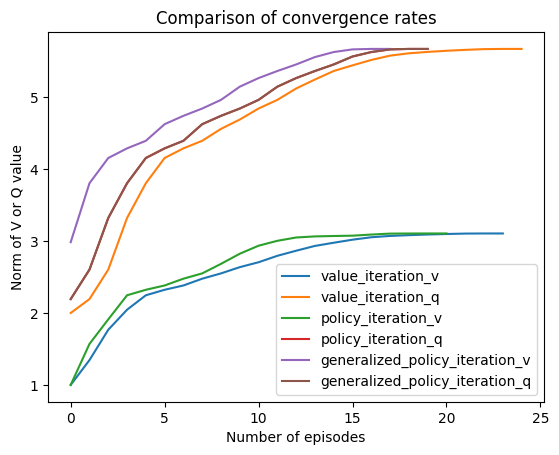

In [81]:
plot_convergence_vi_pi_generalized(env,False)